In [62]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import model_selection, preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [63]:
df_train = pd.read_csv('clean_train.csv')
df_test = pd.read_csv('clean_test.csv')
id_test = df_test.ID

In [64]:
y_train = df_train["y"]
x_train = df_train.drop(["y"], axis=1)
x_test = df_test#.drop(["ID"], axis=1)

print x_train.shape, x_test.shape, y_train.shape

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True) 

print x_train.shape, x_test.shape

(4209, 311) (4209, 311) (4209,)
(4209, 311) (4209, 311)


In [65]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=2020)

dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
dtest = xgb.DMatrix(x_test)
# dtrain = xgb.DMatrix(x_train, y_train)
# dtest = xgb.DMatrix(x_test)

In [72]:
xgb_params = {}
xgb_params['objective'] = 'reg:linear'
xgb_params['eta'] = 0.02
xgb_params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True, verbose_eval=10)



[0]	train-r2:-59.3539	valid-r2:-62.3978
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-r2:-39.4618	valid-r2:-41.4533
[20]	train-r2:-26.1735	valid-r2:-27.47
[30]	train-r2:-17.2968	valid-r2:-18.1346
[40]	train-r2:-11.367	valid-r2:-11.9029
[50]	train-r2:-7.40526	valid-r2:-7.74834
[60]	train-r2:-4.75822	valid-r2:-4.97534
[70]	train-r2:-2.98936	valid-r2:-3.12728
[80]	train-r2:-1.80658	valid-r2:-1.89587
[90]	train-r2:-1.01496	valid-r2:-1.07613
[100]	train-r2:-0.484566	valid-r2:-0.528396
[110]	train-r2:-0.128979	valid-r2:-0.161956
[120]	train-r2:0.109422	valid-r2:0.0824
[130]	train-r2:0.269738	valid-r2:0.245826
[140]	train-r2:0.377791	valid-r2:0.355197
[150]	train-r2:0.450505	valid-r2:0.427605
[160]	train-r2:0.500333	valid-r2:0.476538
[170]	train-r2:0.534331	valid-r2:0.509206
[180]	train-r2:0.557909	valid-r2:0.530665
[190]	train-r2:0.574352	valid-r2:0.544818
[200]	train-r2:0.586283	valid-r

In [104]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 2,
    'gamma': 4,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'objective': 'reg:linear',
#     'eval_metric': 'rmse',
    'silent': 1
}

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=10, show_stdv=False, feval=xgb_r2_score, maximize=True)
#     'eta': 0.05,
#     'max_depth': 3,
#     'gamma': 2,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1
# [120]	train-r2:0.633304	test-r2:0.565426

[0]	train-r2:-50.1848	test-r2:-50.6579
[10]	train-r2:-5.68273	test-r2:-5.72465
[20]	train-r2:-0.205753	test-r2:-0.211611
[30]	train-r2:0.476759	test-r2:0.46688
[40]	train-r2:0.571249	test-r2:0.554633
[50]	train-r2:0.592542	test-r2:0.566575
[60]	train-r2:0.601537	test-r2:0.569141
[70]	train-r2:0.607795	test-r2:0.567889


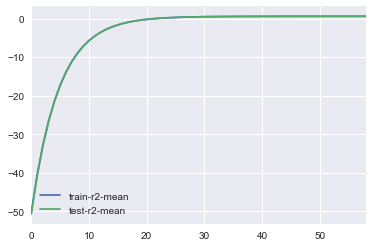

In [105]:
cv_output[['train-r2-mean', 'test-r2-mean']].plot()

In [106]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [107]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 60))
# xgb.plot_importance(model, height=0.5, ax=ax)

In [108]:
y_pred_tr = model.predict(dtrain)
print 'Train:', xgb_r2_score(y_pred_tr, dtrain)

y_pred_val = model.predict(dvalid)
print 'Val:', xgb_r2_score(y_pred_val, dvalid)
# Train: ('r2', 0.60473081638029402)
# Val: ('r2', 0.56729882111087759)

# Train: ('r2', 0.59019025799407598)
# Val: ('r2', 0.56887638635435567)

# 0.6
# Train: ('r2', 0.58691791141382998)
# Val: ('r2', 0.5681459527865238)

Train: ('r2', 0.58691791141382998)
Val: ('r2', 0.5681459527865238)


In [109]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'ID': id_test, 'y': y_predict})
output.head()

,ID,y
0,1,78.751579
1,2,98.329315
2,3,82.763237
3,4,79.310577
4,5,114.434006


In [110]:
output.to_csv('submissions/xgb1_fixed_lte10data_thrown+id_cosample0606.csv', index=False)

In [111]:
output.shape

(4209, 2)

In [112]:
sample = pd.read_csv('sample_submission.csv')
sample.shape

(4209, 2)

In [113]:
sample.head()

,ID,y
0,1,100.669318
1,2,100.669318
2,3,100.669318
3,4,100.669318
4,5,100.669318
